
# Clustering and segmenting locations of Goa

In this project I will be clustering and segmenting towns of Goa,India based on the frequency of visits to different places in the towns.
We will segment the towns into areas that are suitable to start a particular type of business, for this instance into areas suitable for starting up a restraurant.

Lets import the libraries

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import matplotlib.pyplot as plt

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests 
 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

from bs4 import BeautifulSoup
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          84 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0     conda-forge

The following packages will be UPDATED:

    geopy:         1.11.0-py36_0 conda-forge --> 1.18.1-py_0 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
geographiclib-1.49   | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executi

Now lets use the BeautifulSoup library to extract the location data of goa from the site https://www.mapsofindia.com/pincode/india/goa/
Goa is divided into 2 Districts. So lets first do it for North-Goa.

In [2]:
html1 = 'https://www.mapsofindia.com/pincode/india/goa/north-goa/'
page = requests.get(html1)
text = page.text
soup = BeautifulSoup(text, 'html.parser')


In [3]:
table = soup.find('table')
rows = table.findAll('tr')
columns = rows[1].findAll('td')
rows = rows[1:]
no_of_cols = len(columns)
no_of_rows = len(rows)
#since the row containg the column names is used we subtract a row from the total no of rows
no_of_rows = no_of_rows - 1
no_of_rows

142

In [4]:
cols= list()

for i in range(no_of_cols):
    if i == no_of_cols - 1:
        cols.append(columns[i].string[:-1].lower())
    else:
        cols.append(columns[i].string.lower())

north_goa_df = pd.DataFrame(columns = cols, index = range(no_of_rows))

for i in range(no_of_rows):
    new_rows = rows[i+1].findAll('td')
    for j in range(no_of_cols):
        north_goa_df.iloc[i,j] = new_rows[j].string
        if north_goa_df.iloc[i,j] == None:
            north_goa_df.iloc[i,j] = new_rows[j].a.string 
            

print(north_goa_df.shape)
north_goa_df.head()

(142, 4)


,location,pincode,state,district
0,Advalpal,403503,Goa,North Goa
1,Advoi,403530,Goa,North Goa
2,Agarwada,403512,Goa,North Goa
3,Aldona,403508,Goa,North Goa
4,Alto Betim,403521,Goa,North Goa


Lets do it for South Goa now

In [5]:
html2 = 'https://www.mapsofindia.com/pincode/india/goa/south-goa/'
page = requests.get(html2)
text = page.text
soup = BeautifulSoup(text, 'html.parser')

table = soup.find('table')
rows = table.findAll('tr')
columns = rows[1].findAll('td')
rows = rows[1:]
no_of_cols = len(columns)
no_of_rows = len(rows)
#since the row containg the column names is used we subtract a row from the total no of rows
no_of_rows = no_of_rows - 1

cols= list()

for i in range(no_of_cols):
    if i == no_of_cols - 1:
        cols.append(columns[i].string[:-1].lower())
    else:
        cols.append(columns[i].string.lower())

south_goa_df = pd.DataFrame(columns = cols, index = range(no_of_rows))

for i in range(no_of_rows):
    new_rows = rows[i+1].findAll('td')
    for j in range(no_of_cols):
        south_goa_df.iloc[i,j] = new_rows[j].string
        if south_goa_df.iloc[i,j] == None:
            south_goa_df.iloc[i,j] = new_rows[j].a.string 
            

print(south_goa_df.shape)
south_goa_df.head()

(121, 4)


,location,pincode,state,district
0,A.P.dabolim,403801,Goa,South Goa
1,A.P.terminal,403801,Goa,South Goa
2,Agapur Adpoi,403401,Goa,South Goa
3,Agonda,403702,Goa,South Goa
4,Ambaulim,403705,Goa,South Goa


Now lets combine the dataframes of north goa and south goa 

In [6]:
goa_df = north_goa_df.append(south_goa_df)
print(goa_df.columns)
goa_df.sort_values(['location','pincode '],inplace = True)
goa_df = goa_df[['pincode ','location','district']]
goa_df.reset_index(inplace=True)
goa_df.drop('index',axis=1,inplace=True)
print(goa_df.shape)

Index(['location', 'pincode ', 'state ', 'district'], dtype='object')
(263, 3)


In [7]:
locs= list(goa_df['location'].unique())
index=range(len(locs))
len(locs)

259

In [8]:
new_df = goa_df

new_df.reset_index(inplace=True)
new_df.drop('index',axis=1,inplace=True)
new_df.shape
new_df.head(10)

,pincode,location,district
0,403801,A.P.dabolim,South Goa
1,403801,A.P.terminal,South Goa
2,403503,Advalpal,North Goa
3,403530,Advoi,North Goa
4,403401,Agapur Adpoi,South Goa
5,403512,Agarwada,North Goa
6,403702,Agonda,South Goa
7,403508,Aldona,North Goa
8,403521,Alto Betim,North Goa
9,403521,Alto-porvorim,North Goa


Now we get the location coordinates of Goa using the Nominatim function from Geopy

In [9]:
for i in range(0,len(locs)):
    geolocator = Nominatim()
    address = '{},Goa,india'.format(locs[i])
    location = geolocator.geocode(address)
    if(location != None):
        latitude = location.latitude
        longitude = location.longitude
        new_df.loc[i,'latitude'] = latitude
        new_df.loc[i,'longitude'] = longitude
        
goa_loc = new_df
goa_loc.head(10)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


,pincode,location,district,latitude,longitude
0,403801,A.P.dabolim,South Goa,NaN,NaN
1,403801,A.P.terminal,South Goa,NaN,NaN
2,403503,Advalpal,North Goa,NaN,NaN
3,403530,Advoi,North Goa,NaN,NaN
4,403401,Agapur Adpoi,South Goa,NaN,NaN
5,403512,Agarwada,North Goa,NaN,NaN
6,403702,Agonda,South Goa,15.040267,73.990318
7,403508,Aldona,North Goa,15.588825,73.874076
8,403521,Alto Betim,North Goa,NaN,NaN
9,403521,Alto-porvorim,North Goa,NaN,NaN


In [10]:
goa_loc.dropna(subset = ['latitude','longitude'],axis=0,inplace=True) #removing any rows with missing values
print(goa_loc.shape)


(145, 5)


Lets visualise the dataframe

In [11]:
goa_map = folium.Map(location=[goa_loc.latitude.mean(),goa_loc.longitude.mean()],zoom_start=10)

for lat,lng,district,location in zip(goa_loc['latitude'],goa_loc['longitude'],goa_loc['district'],goa_loc['location']):
    label = '{}'.format(location)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(goa_map)  
    
goa_map

In [12]:
CLIENT_ID = 'KKXTSUNT2EBBQCTDDYKZHFFJI2S1QBNMADIDFA3IBMQV0MY2' 
CLIENT_SECRET = 'MZFRDDVMZQEWNSPT4KG04ULHHTH5WVTQTCLC3CHMGZSYC124' 
VERSION = '20180105' 

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: KKXTSUNT2EBBQCTDDYKZHFFJI2S1QBNMADIDFA3IBMQV0MY2
CLIENT_SECRET:MZFRDDVMZQEWNSPT4KG04ULHHTH5WVTQTCLC3CHMGZSYC124


Now lets define a function to get the nearby venues using foursquare.

In [13]:
def getNearbyVenues(names, pin,latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name,pin, lat, lng in zip(names, pin,latitudes, longitudes):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            pin,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['location', 
                  'pincode ',
                  'location Latitude', 
                  'location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

goa_venues = getNearbyVenues(names=goa_loc['location'],pin = goa_loc['pincode '],
                                   latitudes=goa_loc['latitude'],
                                   longitudes=goa_loc['longitude']
                                  )


In [14]:
goa_venues.shape

(649, 8)

Lets group the dataframe based on location and then one-hot-encode them

In [15]:
goa_venues.groupby('location').count()

,pincode,location Latitude,location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
location,,,,,,,
Agonda,14,14,14,14,14,14,14
Aldona,2,2,2,2,2,2,2
Anjuna,18,18,18,18,18,18,18
Aquem,6,6,6,6,6,6,6
Arambol,29,29,29,29,29,29,29
Arpora,17,17,17,17,17,17,17
Assagao,4,4,4,4,4,4,4
Assolna,1,1,1,1,1,1,1
Baga,9,9,9,9,9,9,9


In [16]:
# one hot encoding
onehot = pd.get_dummies(goa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['location'] = goa_venues['location'] 
onehot['pincode '] = goa_venues['pincode '] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]]+[onehot.columns[-2]] + list(onehot.columns[:-2])
onehot = onehot[fixed_columns]
print(onehot.shape)
onehot.head()

(649, 136)


,pincode,location,ATM,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Bed & Breakfast,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Bus Station,Café,Campground,Caribbean Restaurant,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Service,Farm,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gastropub,German Restaurant,Gift Shop,Goan Restaurant,Grocery Store,Gym,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Men's Store,Mobile Phone Shop,Motel,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Night Market,Nightclub,Other Great Outdoors,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Resort,Rest Area,Restaurant,River,Romanian Restaurant,Russian Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Summer Camp,Tapas Restaurant,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,403702,Agonda,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,403702,Agonda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,403702,Agonda,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,403702,Agonda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,403702,Agonda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
grouped = onehot.groupby(['location','pincode ']).mean().reset_index()
grouped.head()

,location,pincode,ATM,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Bed & Breakfast,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Bus Station,Café,Campground,Caribbean Restaurant,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Service,Farm,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gastropub,German Restaurant,Gift Shop,Goan Restaurant,Grocery Store,Gym,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Kerala Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Men's Store,Mobile Phone Shop,Motel,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Night Market,Nightclub,Other Great Outdoors,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Resort,Rest Area,Restaurant,River,Romanian Restaurant,Russian Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Summer Camp,Tapas Restaurant,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,Agonda,403702,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.071429,0.0,0.000000,0.071429,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.214286,0.071429,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0
1,Aldona,403508,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.500000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Anjuna,403509,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.055556,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.0,0.166667,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Aquem,403601,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0

Now lets define a function to get top 5 venues from each town.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[0:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['location','pincode ']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['location'] = grouped['location']
venues_sorted['pincode '] = grouped['pincode ']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 2:] = return_most_common_venues(grouped.iloc[ind, 2:], num_top_venues)

venues_sorted.sort_values('pincode ',inplace=True)
print(venues_sorted.shape)


(106, 7)


## Clustering

Now that we have the top 5 venues of each town lets perform K-means clustering on the dataframe.

In [20]:
kclusters =6
grouped_clustering = grouped.drop(['location','pincode '], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)
kmeans.labels_


array([4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0, 4, 4, 5, 4, 0, 4,
       0, 2, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 0, 4, 3, 4, 0, 4,
       4, 4, 4, 1, 4, 0, 4, 0, 4, 4, 4, 0, 4, 0, 0, 4, 4, 2, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 1, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 2, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0], dtype=int32)

In [21]:
goa_merged = pd.DataFrame(columns=['location','pincode '])
goa_merged['location'] = grouped['location']
goa_merged['pincode '] = grouped['pincode ']
goa_merged['Cluster'] = kmeans.labels_
goa_merged.shape

(106, 3)

Now lets combine the venues dataframe with the original dataframe to get the new dataframe with coordinates of each town.

In [22]:
venues_sorted.sort_values('location',inplace=True)
venues_sorted.reset_index(inplace=True)
goa_merged.sort_values('location',inplace=True)
goa_merged.reset_index(inplace=True)
venues_sorted.shape

(106, 8)

In [23]:
venues_sorted.drop('index',axis=1,inplace=True)
venues_sorted.head()

,location,pincode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agonda,403702,Indian Restaurant,Resort,Beach,Snack Place,Bistro
1,Aldona,403508,Indian Restaurant,Market,Food Court,Food & Drink Shop,Food
2,Anjuna,403509,Indian Restaurant,Café,Burger Joint,Italian Restaurant,Juice Bar
3,Aquem,403601,Deli / Bodega,Train Station,Coffee Shop,Clothing Store,Multiplex
4,Arambol,403524,Indian Restaurant,Resort,Restaurant,Asian Restaurant,Café


In [24]:
goa_merged.drop('index',axis=1,inplace=True)
goa_merged.head()


,location,pincode,Cluster
0,Agonda,403702,4
1,Aldona,403508,0
2,Anjuna,403509,4
3,Aquem,403601,4
4,Arambol,403524,0


In [25]:
goa_merged.drop('pincode ',axis=1,inplace=True)
goa_merged = goa_merged.join(venues_sorted.set_index('location'), on='location')

goa_merged.drop('pincode ',axis=1,inplace=True)
goa_merged = goa_merged.join(goa_loc.set_index('location'),on='location')
print(goa_merged.shape)
goa_merged.head() 

(113, 11)


,location,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,pincode,district,latitude,longitude
0,Agonda,4,Indian Restaurant,Resort,Beach,Snack Place,Bistro,403702,South Goa,15.040267,73.990318
1,Aldona,0,Indian Restaurant,Market,Food Court,Food & Drink Shop,Food,403508,North Goa,15.588825,73.874076
2,Anjuna,4,Indian Restaurant,Café,Burger Joint,Italian Restaurant,Juice Bar,403509,North Goa,15.584865,73.743944
3,Aquem,4,Deli / Bodega,Train Station,Coffee Shop,Clothing Store,Multiplex,403601,South Goa,15.272229,73.970029
4,Arambol,0,Indian Restaurant,Resort,Restaurant,Asian Restaurant,Café,403524,North Goa,15.678065,73.705411


Lets visualise the clustered towns.

In [26]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for pin,lat, lon, loc, cluster in zip(goa_merged['pincode '],goa_merged['latitude'], goa_merged['longitude'], goa_merged['location'], goa_merged['Cluster']):
    label = folium.Popup(str(loc) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
cluster1 = goa_merged.loc[goa_merged['Cluster'] == 0, goa_merged.columns[[0] + list(range(2, 7))]]
cluster1.reset_index(inplace=True)
cluster1.drop('index',axis=1,inplace=True)
cluster1

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aldona,Indian Restaurant,Market,Food Court,Food & Drink Shop,Food
1,Arambol,Indian Restaurant,Resort,Restaurant,Asian Restaurant,Café
2,Arpora,Indian Restaurant,Seafood Restaurant,Restaurant,Hotel,Convenience Store
3,Bandora,Indian Restaurant,Snack Place,Asian Restaurant,Farm,Food & Drink Shop
4,Benaulim,Indian Restaurant,Restaurant,Resort,Hotel,Seafood Restaurant
5,Betim,Indian Restaurant,Casino,Boat or Ferry,Restaurant,Seafood Restaurant
6,Betul,Indian Restaurant,Asian Restaurant,Farm,Food Court,Food & Drink Shop
7,Camurlim,Indian Restaurant,Wine Shop,Event Service,Food & Drink Shop,Food
8,Camurlim,Indian Restaurant,Wine Shop,Event Service,Food & Drink Shop,Food
9,Cansarvornem,Indian Restaurant,Restaurant,Train Station,Event Service,Food & Drink Shop


In [28]:
cluster2 = goa_merged.loc[goa_merged['Cluster'] == 1, goa_merged.columns[[0] + list(range(2, 7))]]
cluster2.reset_index(inplace=True)
cluster2.drop('index',axis=1,inplace=True)
cluster2

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ibrampur,IT Services,Zoo,Farm,Food Court,Food & Drink Shop
1,Quela,IT Services,Zoo,Farm,Food Court,Food & Drink Shop


In [29]:
cluster3 = goa_merged.loc[goa_merged['Cluster'] == 2, goa_merged.columns[[0] + list(range(2, 7))]]
cluster3.reset_index(inplace=True)
cluster3.drop('index',axis=1,inplace=True)
cluster3

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cansaulim,ATM,Football Stadium,Diner,Donut Shop,Dumpling Restaurant
1,Colva,ATM,Football Stadium,Diner,Donut Shop,Dumpling Restaurant
2,Mulgao,ATM,Restaurant,Event Service,Food & Drink Shop,Food
3,Sem Saligao,ATM,Football Stadium,Diner,Donut Shop,Dumpling Restaurant
4,Vasco-da-gama,ATM,Football Stadium,Diner,Donut Shop,Dumpling Restaurant


In [30]:
cluster4 = goa_merged.loc[goa_merged['Cluster'] == 3, goa_merged.columns[[0] + list(range(2, 7))]]
cluster4.reset_index(inplace=True)
cluster4.drop('index',axis=1,inplace=True)
cluster4

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Curtorim,Moving Target,Zoo,Fast Food Restaurant,Food Court,Food & Drink Shop
1,Nio Dona paula,Moving Target,Zoo,Fast Food Restaurant,Food Court,Food & Drink Shop


In [31]:
cluster5 = goa_merged.loc[goa_merged['Cluster'] == 4, goa_merged.columns[[0] + list(range(2, 7))]]
cluster5.reset_index(inplace=True)
cluster5.drop('index',axis=1,inplace=True)
cluster5

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agonda,Indian Restaurant,Resort,Beach,Snack Place,Bistro
1,Anjuna,Indian Restaurant,Café,Burger Joint,Italian Restaurant,Juice Bar
2,Aquem,Deli / Bodega,Train Station,Coffee Shop,Clothing Store,Multiplex
3,Assagao,Hotel,Café,Romanian Restaurant,Seafood Restaurant,Zoo
4,Assolna,Boat or Ferry,Zoo,Fast Food Restaurant,Food Court,Food & Drink Shop
5,Baga,Resort,Hotel,Goan Restaurant,Flea Market,Café
6,Baina,Performing Arts Venue,Beach,Zoo,Food & Drink Shop,Food
7,Balli,Trail,Event Service,Food & Drink Shop,Food,Flea Market
8,Batim,Goan Restaurant,Zoo,Fast Food Restaurant,Food Court,Food & Drink Shop
9,Bicholim,Department Store,South Indian Restaurant,Furniture / Home Store,Bus Station,Food Court


In [32]:
cluster6 = goa_merged.loc[goa_merged['Cluster'] == 5, goa_merged.columns[[0] + list(range(2, 7))]]
cluster6.reset_index(inplace=True)
cluster6.drop('index',axis=1,inplace=True)
cluster6

,location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Borim,Indian Restaurant,Football Stadium,Diner,Donut Shop,Dumpling Restaurant
1,Querim,Indian Restaurant,Football Stadium,Diner,Donut Shop,Dumpling Restaurant
2,Sinquerim,Indian Restaurant,Football Stadium,Diner,Donut Shop,Dumpling Restaurant


---    
Lets analyze the clusters for the frequency of restaurants visits

In [33]:
restaurants= []
cols = ['1st','2nd','3rd','4th','5th']
for i in range(kclusters): 
    rlist = []
    for col in cols:
        df =  goa_merged.loc[goa_merged['Cluster'] == i, goa_merged.columns[[0] + list(range(2, 7))]]
        list1 = df['{} Most Common Venue'.format(col)].str.contains('restaurant', case=False).astype(int)
        rlist.extend(list(list1))
    restaurants.append(sum(rlist))


Text(0.5, 1.0, 'Visit frequency of restaurants per cluster')

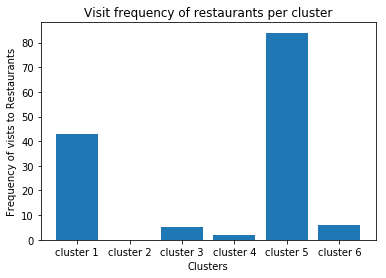

In [34]:
clusters = ['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6',]
plt.bar(clusters,restaurants)
plt.xlabel('Clusters')
plt.ylabel("Frequency of vists to Restaurants")
plt.title('Visit frequency of restaurants per cluster')

### Inference
We see that locations from cluster 1, cluster 6 and cluster 5 show a very good rate of visits to restaurants. Locations from these clusters are ideal to startup an restraurant since people are more likely to visit a new restaurant in these areas rather then the ones in cluster 2,3 and 4. These locations provide a very high chance of profit and investors are less likely to suffer loss.
 
Locations from cluster 5 shows the highest frequency of visits to restaurants and these locations are likely to provide the most profit for an restaurant owner as people from these location show a high tendency to visit different restaurants and food places especially Indian Restaurants.
   


Additionally we can also infer that if someone wants to start an residency the locations from cluster 5 are ideal since these locations have the different day-to-day life services available and are suitable for tourists as well as people with a high class lifestyle who would like to have quick access to leisure services on day to day basis.

## Thank You